In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from nets.ColorHandPose3DNetwork import ColorHandPose3DNetwork
from utils.general import detect_keypoints, trafo_coords, plot_hand, plot_hand_3d

In [2]:
import numpy as np
import torch
import torch.nn as nn

cap.release()
cv2.destroyAllWindows()

# take  a photo

import cv2
def get_image(cap):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)[:,160:-160,:]
    frame = cv2.resize(frame , (int(frame.shape[1]/3), int(frame.shape[0]/3)))
    return frame

cap = cv2.VideoCapture(0)
img = get_image(cap)
plt.imshow(img)

#cap.release()
#cv2.destroyAllWindows()

# get frature from photo

def get_feature(img,sess,sess_args):
    image_v = np.expand_dims((img.astype('float') / 255.0) - 0.5, 0)

    hand_scoremap_v, image_crop_v, scale_v, center_v,\
    keypoints_scoremap_v, keypoint_coord3d_v = sess.run(sess_args,
                                                        feed_dict={image_tf: image_v})
    coord_hw_crop = detect_keypoints(np.squeeze(keypoints_scoremap_v))
    center_v = np.array([0.,0.])
    scale_v = np.array([1.])
    coord_hw = trafo_coords(coord_hw_crop, center_v, scale_v, 256)
    return coord_hw#/100#coord_hw_crop# - center_v

hands_2d = get_feature(img,sess,[hand_scoremap_tf, image_crop_tf, scale_tf, center_tf,
                    keypoints_scoremap_tf, keypoint_coord3d_tf])

plt.plot(hands_2d[:,1],-hands_2d[:,0])

# ready the network

# network input
image_tf = tf.placeholder(tf.float32, shape=(1, 240, 320, 3))
hand_side_tf = tf.constant([[1.0, 0.0]])  # left hand (true for all samples provided)
evaluation = tf.placeholder_with_default(True, shape=())

# build network
net = ColorHandPose3DNetwork()
hand_scoremap_tf, image_crop_tf, scale_tf, center_tf,\
keypoints_scoremap_tf, keypoint_coord3d_tf = net.inference(image_tf, hand_side_tf, evaluation)

# Start TF
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# initialize network
net.init(sess)

# gather test_data

%matplotlib inline
# Queue
from random import randint
from collections import deque

#Plot
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Queue
num = 10
# Plot
plt.ion()
fig = plt.figure()

data_set = []
for i in range(num):
    print('itr',i)
    # get hand
    img = get_image(cap)
    data_set.append(get_feature(img,sess,[hand_scoremap_tf, image_crop_tf, scale_tf, center_tf,
                    keypoints_scoremap_tf, keypoint_coord3d_tf]))
    #fig = plt.figure(1)
    ax1 = fig.add_subplot(111)
    ax1.cla()
    ax1.imshow(img)
    plot_hand(data_set[-1], ax1)
    
    # Plot
    clear_output(wait = True)
    plt.savefig("mydata/image_test{}.png".format(i), format = 'png', dpi=300)
    display(fig) 

import pickle
data_set = np.array([dd.flatten() for dd in data_set])/100
# data_set = np.array([dd.flatten() for dd in data_set])*100
with open('mukai_dataset_test.pickle',mode='wb') as f:
    pickle.dump(data_set,f)

# load data

In [3]:
import pickle
with open('mukai_dataset_test.pickle',mode='rb') as f:
    test= pickle.load(f)

In [4]:
import pickle
with open('mukai_dataset.pickle',mode='rb') as f:
    train = pickle.load(f)

In [5]:
train.shape,test.shape

((100, 42), (10, 42))

# get Y

In [6]:
from sklearn.manifold import TSNE

In [7]:
Y = TSNE(n_components=2, random_state=0,perplexity=30,verbose=True).fit_transform(train)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 1.556115
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.254372
[t-SNE] KL divergence after 1000 iterations: 0.316927


## problem[solved]
- c.f https://qiita.com/koshian2/items/7aab45dafbdbd959d8fc
### which we shold use
- ~~mean sigma of X over all row~~
- the optimal sigma of new row

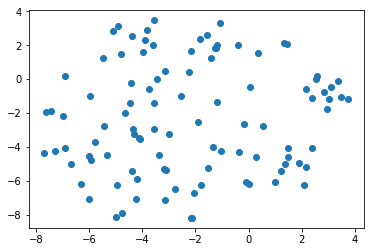

In [8]:
plt.scatter(Y[:, 0], Y[:, 1])

In [9]:
def get_reduced_posi_1nn(X, X_reduced,new_x):
    min_dist = 1000
    min_id = 1000000000
    # get new_position
    for j, d in enumerate(X):
        dist = np.linalg.norm(d - new_x)
        if min_dist > dist:
            min_id = j
            min_dist = dist
    return X_reduced[min_id]

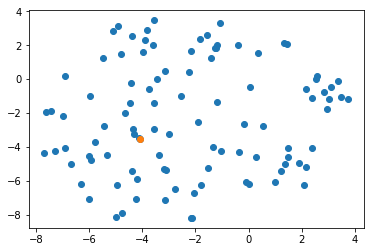

In [10]:
plt.scatter(Y[:, 0], Y[:, 1])
y_new = get_reduced_posi_1nn(train,Y,test[0])
plt.scatter([y_new[0]],[y_new[1]])

In [11]:
X = torch.tensor(train)

# find sigma with back tracking line search

Text(0,0.5,'peplexity')

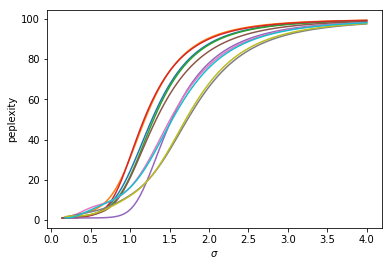

In [12]:
for i in range(10):
    x_new = torch.tensor(test[i])
    papa = []
    for sigma in np.linspace(0.1,4,100):
        perp = 30
        twosigma = 2*torch.pow(torch.tensor(sigma),2)
        p = torch.exp(-torch.pow(X - x_new,2).sum(dim=1)/twosigma)
        P = (p/p.sum())#.detach()
        H = (-P*torch.log2(P)).sum()
        #loss_p = torch.abs(torch.tensor(perp, requires_grad=True,dtype=torch.double) - torch.pow(2,H))
        loss_p = torch.pow(2,H)#torch.tensor(perp, requires_grad=True,dtype=torch.double)# - torch.pow(2,H)
        papa.append(loss_p.detach())
    plt.plot(np.linspace(0.1,4,100),papa)
plt.xlabel('$\sigma$')
plt.ylabel('peplexity')

- minitest

v = torch.tensor([0,1,2])
vv = torch.cat((v,v))
for i in range(6):
    print(torch.cat((vv[:i],vv[i+1:])))

## regacy
```
def f(sigma,perp,X,x_new):
    p = torch.exp(-torch.pow(X - x_new,2).sum(dim=1)/(2*torch.pow(sigma,2)))
    P = (p/p.sum())
    H = (-P*torch.log2(P)).sum()
    loss_p = torch.abs(torch.tensor(perp, requires_grad=True,dtype=torch.double) - torch.pow(2,H))
    return loss_p
def line_search_single(sigma,p,grad,f,perp,X,x_new):
    c = 1e-4
    rho = 0.7
    alpha = 1.0
    while True:
        if f(sigma+alpha*p, perp,X,x_new)<= f(sigma, perp,X,x_new)+c*alpha*grad*p:
            break
        else:
            alpha *= rho
    return alpha*p
def find_sigma_single(f,perp,X,x_new):
    # back tracking line search
    sigma = torch.tensor(1.0, requires_grad=True,dtype=torch.double)
    for _  in range(100):
        loss = f(sigma,perp,X,x_new)
        loss.backward()
        grad = sigma.grad
        p = - grad
        stp = line_search(sigma,p,grad,f,perp,X,x_new)
        sigma.data.add_(stp)
        sigma.grad.data.zero_()
        print(sigma.detach().numpy(),loss.detach().numpy())
        if loss<1e-2:
            break  
    return sigma.detach()
    
def line_search(sigma,d,loss,p,grad,perp):
    c = 1e-4
    rho = 0.7
    alpha = 1.0
    while True:
        if loss(sigma+alpha*p ,perp,d)<= loss(sigma,perp,d)+c*alpha*grad*p:
            break
        else:
            alpha *= rho
    return alpha*p
```

- mini test

torch.tensor([1,2,3],dtype=torch.float).view((3,1))

ddd = (torch.ones((3,3))*torch.tensor([1,2,3],dtype=torch.float).view((3,1)))

ddd

ddd/ddd.sum(dim=1).view((3,1))

## ragacy
```
def line_search(sigma,d,loss,p,grad,perp):
    c = 1e-4
    rho = 0.7
    alpha = 1.0
    while True:
        if loss(sigma+alpha*p ,perp,d)<= loss(sigma,perp,d)+c*alpha*grad*p:
            break
        else:
            alpha *= rho
    return alpha*p
```

def loss_sigma(sigma,perp,d):
    p = torch.exp(-d/(2*torch.pow(sigma,2)))
    P = (p/p.sum())
    H = (-P*torch.log2(P)).sum()
    loss_p = torch.abs(torch.tensor(perp, requires_grad=True,dtype=torch.double) - torch.pow(2,H))
    return loss_p

def find_sigma(loss,pepr,d):
    sigma = torch.tensor(1.0, requires_grad=True,dtype=torch.double)
    for _ in range(100):
        loss = loss_sigma(sigma,perp,d)
        loss.backward()
        grad = sigma.grad
        p = - grad
        stp = line_search(sigma,d,loss_sigma,p,grad,perp)
        sigma.data.add_(stp)
        sigma.grad.data.zero_()
        #print(sigma.detach().numpy(),loss.detach().numpy())
        if loss<1e-1:
            break  
    return sigma
    

def find_all_sigma(perp,D_l2):
    # back tracking line search
    sigmas = []
    for i in range(D_l2.shape[0]):
        d = torch.cat((D_l2[i][:i],D_l2[i][i+1:]))
        sigmas.append(find_sigma(loss_sigma,pepr,d))
    return torch.tensor(sigmas)

def find_all_sigma_direct(perp,D_l2):
    # back tracking line search
    sigmas = torch.ones(D_l2.shape[0],
                    requires_grad=True,
                    dtype=torch.double)
    D = torch.exp(-D_l2/(2*torch.pow(sigmas,2).view((sigmas.shape[0],1)))) -\
                                                torch.eye(D_l2.shape[0],dtype=torch.double)
    P = D/D.sum(dim=1).view((D.shape[0],1))
    H = (-P*torch.log2(P+torch.eye(P.shape[0],dtype=torch.double))).sum(dim=1)
    perp = torch.tensor(perp, requires_grad=True,dtype=torch.double)
    loss_p = torch.abs(perp - torch.pow(2,H))
    #print(loss_p)
    #raise
    
    
    return torch.tensor(sigmas)



        
def a():
    sigma = torch.tensor(1.0, requires_grad=True,dtype=torch.double)
    for _  in range(30):
        loss = f(sigma,perp,X,x_new)
        loss.backward()
        grad = sigma.grad
        p = - grad
        stp = line_search(sigma,p,grad,f,perp,X,x_new)
        sigma.data.add_(stp)
        sigma.grad.data.zero_()
        # print(sigma.detach().numpy(),loss.detach().numpy())
        if loss<1e-1:
            break  
    return sigma.detach()

In [13]:
def get_reduced_posi_1nn(X, X_reduced,new_x):
    min_dist = 1000
    min_id = 1000000000
    # get new_position
    for j, d in enumerate(X):
        dist = np.linalg.norm(d - new_x)
        if min_dist > dist:
            min_id = j
            min_dist = dist
    return X_reduced[min_id]

# multi line binary search

In [ ]:
def get_high_low(D_l2,sigmas,perp):
    # print('sig,D_l2:',sigmas.shape,D_l2.shape)
    D = torch.exp(-D_l2/(2*torch.pow(sigmas,2).view((sigmas.shape[0],1)))) -\
                                                torch.eye(D_l2.shape[0],dtype=torch.double)
    P = D/D.sum(dim=1).view((D.shape[0],1))
    H = (-P*torch.log2(P+torch.eye(P.shape[0],dtype=torch.double))).sum(dim=1)
    req_perp = torch.tensor(perp, requires_grad=True,dtype=torch.double)
    diff = torch.pow(2,H) - req_perp
    return -torch.sign(diff),diff
    
    
SIGMAX = 20
def multi_line_search(D_l2,perp):
    l = torch.zeros((D_l2.shape[0],1),dtype=torch.double)
    h = SIGMAX*torch.ones((D_l2.shape[0],1),dtype=torch.double)
    lh = torch.cat((l,h),dim=1)
    A = torch.tensor([[3,1],[1,3]],dtype=torch.double)
    B = torch.tensor([[-1,1],[-1,1]],dtype=torch.double)
    # losses = []
    for i in range(100):
        x,diff = get_high_low(D_l2,lh.mean(dim=1),perp)
        # losses.append(diff.abs().mean().detach().numpy())
        lh = (A@(lh.transpose(0,1)) + B@((lh*x.view((x.shape[0],1))).transpose(0,1)))/4
        lh = lh.transpose(0,1)
        if diff.abs().max() < 1e-2:
            break
    assert lh.max()<20,'you should make SIGMAX larger'
    return lh.mean(dim=1)# ,losses

# distance matrix

In [15]:
def make_D_l2(x):
    xx = x.expand(x.shape[0],x.shape[0],x.shape[1])
    return torch.pow(xx - xx.transpose(0,1),2).sum(dim=2)
#pepr = 30
D_l2 = make_D_l2(X)
#sigmas = find_all_sigma(perp,D_l2)

## binary search vs grad

In [18]:
import time
st = time.time()
sigmas_line = multi_line_search(D_l2,perp)
print(time.time()-st)

0.039190053939819336


import time
st = time.time()
pepr = 30
D_l2 = make_D_l2(X)
sigmas_grad = find_all_sigma(perp,D_l2)
print(time.time()-st)
> 7.241201877593994[sec]

(sigmas_grad - sigmas_line).max()
> tensor(0.0015, dtype=torch.float64, grad_fn=<MaxBackward1>)

## find y_new

### let's calcutare P and Q

In [19]:
def get_P(D_l2,sigmas):
    D_ = -D_l2/(2*torch.pow(sigmas,2).view((sigmas.shape[0],1)))
    D = torch.exp(D_) - torch.eye(D_l2.shape[0],dtype=torch.double)
    P_ = (D/(D.sum(dim=1).view((D.shape[0],1))))/D.shape[0]
    return (P_ +P_.transpose(0,1))/2+torch.eye(D_l2.shape[0],dtype=torch.double)
def get_Q(Y,y_new):
    Y_new = torch.cat((Y,y_new.view(1,2)))
    D_ = make_D_l2(Y_new)
    Q_ = (1/(1 + D_ ))- torch.eye(D_.shape[0],dtype=torch.double)
    return Q_/Q_.sum() + torch.eye(D_.shape[0],dtype=torch.double)

# draw tests visualization

In [527]:
test_num = 9

In [529]:
X = torch.tensor(train,dtype=torch.double)
x_new = torch.tensor(test[test_num],dtype=torch.double)
X_new = torch.cat((X,x_new.view(1,42)))
D_l2 = make_D_l2(X_new)
sigmas = multi_line_search(D_l2,perp)
P = get_P(D_l2,sigmas).detach()
y_new = torch.tensor([0,0], requires_grad=True,dtype=torch.double)
Y = torch.tensor(Y, requires_grad=True,dtype=torch.double)

## optimization

In [531]:
def line_search(x,P,p,grad):
    c = 1e-4
    rho = 0.8
    alpha = 100.0
    while True:
        if kl_loss(x+alpha*p,Y,P)<= kl_loss(x,Y,P)+c*alpha*grad@p:
            break
        else:
            alpha *= rho
    return alpha*p
def kl_loss(y_new,Y,P):
    Q = get_Q(Y,y_new)
    loss = (P*torch.log(P/Q)).sum()
    return loss

A = torch.tensor([[1,2],[3,4]],dtype=torch.double)

b = torch.tensor([-1,2],dtype=torch.double)

A_ = torch.inverse(tt)

x = A_ @ b

A@ x

### Ax=B, x = $A^{-1}B$

In [533]:
import copy
def find_y_new_newton(P,Y,y_0=[0, 0]):
    log = []
    y_new = torch.tensor(y_0, requires_grad=True,dtype=torch.double)
    for _ in range(20):
        print('kl_loss',kl_loss(y_new,Y,P).detach().numpy())
        [grad] = torch.autograd.grad(kl_loss(y_new,Y,P), (y_new,), create_graph=True)
        [h1] = torch.autograd.grad(grad[0], y_new, create_graph=True)
        [h2] = torch.autograd.grad(grad[1], y_new, create_graph=True)
        H = torch.cat((h1.view(1,2),h2.view(1,2)))
        p = - torch.inverse(H) @ grad
        print('p',p.detach().numpy())
        #print(torch.inverse(H))
        #print('grad,p',grad.detach().numpy(),p.detach().numpy())
        stp = p#debug #line_search(y_new,P,p,grad)
        log.append(copy.deepcopy(y_new.detach().numpy()))
        y_new.data.add_(stp)
        # print(-grad @ p)
        if abs((-grad @ p)/2)< 1e-3:
            log.append(copy.deepcopy(y_new.detach().numpy()))
            break
        grad.data.zero_()
        H.data.zero_()
    print(kl_loss(y_new,Y,P).detach().numpy())
    return y_new,log

In [534]:
st = time.time()
y_newton,log_nt = find_y_new_newton(P,Y,y_0=get_reduced_posi_1nn(train,Y.detach().numpy(),x_new.detach().numpy()))
#y_new = find_y_new(P,Y)
# print(time.time() - st)

kl_loss 0.3272346818448076
p [ 0.29636076 -2.86598833]
kl_loss 0.337970432820774
p [ 16.20914527 104.66574666]
kl_loss 0.4389200237994671
p [17.20911199 99.79396162]
kl_loss 0.46396234447646956
p [ 34.3920518  199.44154138]
kl_loss 0.48897979425653
p [ 68.76771927 398.81224507]
kl_loss 0.5139911754603174
p [137.52642557 797.58953825]
kl_loss 0.5390010530620363
p [ 275.04813884 1595.16170275]
kl_loss 0.5640105561468367
p [ 550.09386994 3190.31474239]
kl_loss 0.5890199657563001
p [1100.18652309 6380.62515894]
kl_loss 0.614029352014982
p [ 2200.37243456 12761.24815637]
kl_loss 0.6390387324381515
p [ 4400.7445625  25522.49523232]
kl_loss 0.6640481114027109
p [ 8801.48897149 51044.98992453]
kl_loss 0.689057490002652
p [ 17602.97786617 102089.97957901]
kl_loss 0.714066868511442
p [ 35205.95569393 204179.95902301]
kl_loss 0.7390762469974447
p [ 70411.91136865 408359.91797852]
kl_loss 0.7640856254777512
p [140823.82272769 816719.83592329]
kl_loss 0.789095003956632
p [ 281647.64545059 1633439.6

In [535]:
log_nt = np.array(log_nt)

In [537]:
import copy
def find_y_new(P,Y,y_0=[0, 0]):
    y_new = torch.tensor(y_0, requires_grad=True,dtype=torch.double)
    log = []
    for _ in range(100):
        loss = kl_loss(y_new,Y,P)
        loss.backward()
        log.append(copy.deepcopy(y_new.detach().numpy()))
        grad = y_new.grad
        p = - grad
        stp = line_search(y_new,P,p,grad)
        y_new.data.add_(stp)
        y_new.grad.data.zero_()
        print(loss.detach().numpy())# y_new.detach().numpy(),
        if stp.abs().sum()<1e-3:
            log.append(copy.deepcopy(y_new.detach().numpy()))
            break  
    return y_new,log

In [538]:
y_new_1nn = get_reduced_posi_1nn(X.detach().numpy(),Y,x_new.detach().numpy()).detach().numpy()

In [539]:
kls = []
x = []
y = []
for i in np.linspace(-1.25+y_new_1nn[0], y_new_1nn[0]+1.25, 200):
    for j in np.linspace(-1.25+y_new_1nn[1],y_new_1nn[1]+1.25,200):
        y_n = torch.tensor([i,j], requires_grad=True,dtype=torch.double)
        kls.append(kl_loss(y_n,Y,P).detach().numpy())
        x.append(i)
        y.append(j)

In [540]:
st = time.time()
y_new,log = find_y_new(P,Y,y_0=get_reduced_posi_1nn(train,Y.detach().numpy(),x_new.detach().numpy()))
print(time.time() - st)

0.3272346818448076
0.3246192272128825
0.32352586954091467
0.3231389501623199
0.3229350830355793
0.32280865676713116
0.32272290201394754
0.32266226761306316
0.32261899674427513
0.322588419843932
0.3225672280645843
0.3225528695329634
0.32254335382958255
0.3225371708229487
0.32253321972138965
0.3225307290317182
0.32252917600574016
0.3225282159904276
0.3225276265852275
0.32252726665331055
0.32252704777702446
0.3225269151157877
0.3225268349171207
0.3225267865319381
0.32252675738642683
0.3225267398518349
0.32252672931276344
0.32252672298304963
0.1273951530456543


In [541]:
log = np.array(log)

In [542]:
mk =  min(kls)
mi = [i for i in range(len(kls)) if kls[i] ==mk][0]

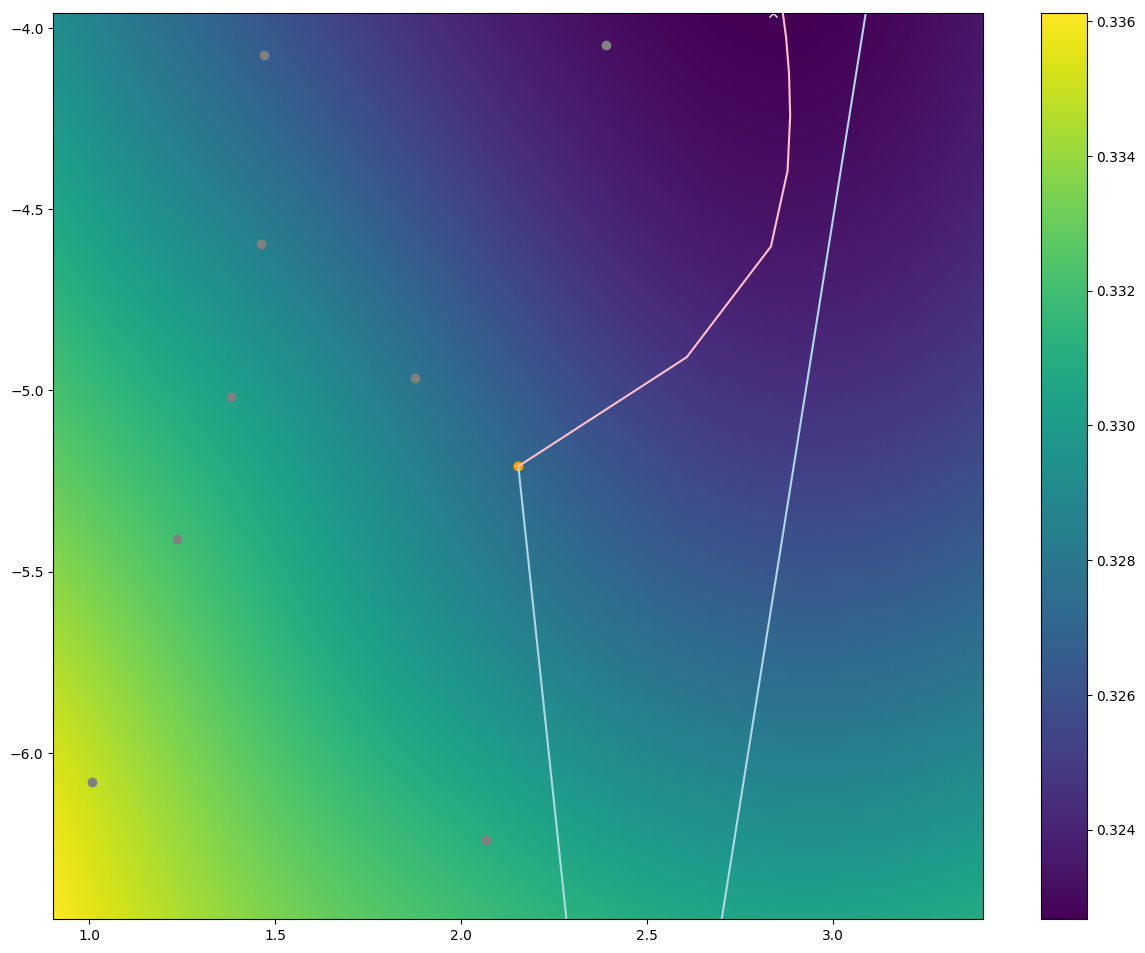

In [543]:
plt.figure(figsize=(15,12),dpi=100)
plt.scatter(x,y,c=kls)
plt.colorbar()
plt.scatter(Y[:,0].detach().numpy(),Y[:,1].detach().numpy(),c='gray')
plt.scatter([y_new[0].detach().numpy()],[y_new[1].detach().numpy()],c='red',zorder=100)
plt.scatter([y_newton[0].detach().numpy()],[y_newton[1].detach().numpy()],c='blue')
plt.scatter([y_new_1nn[0]],[y_new_1nn[1]],c='orange')
plt.plot(log[:,0],log[:,1],c='pink',zorder=100)
plt.plot(log_nt[:,0],log_nt[:,1],c='lightblue')
mk =  min(kls)
mi = [i for i in range(len(kls)) if kls[i] ==mk][0]
plt.plot([x[mi]],[y[mi]],marker='x',c='white')
plt.xlim(-1.25+y_new_1nn[0],y_new_1nn[0]+1.25)
plt.ylim(-1.25+y_new_1nn[1],y_new_1nn[1]+1.25)
plt.savefig('test'+str(test_num)+'.png',dpi=200)

In [544]:
kls2 = []
xxx = []
yyy = []
for i in np.linspace(-10,10,200):
    for j in np.linspace(-10,10,200):
        y_n = torch.tensor([i,j], requires_grad=True,dtype=torch.double)
        kls2.append(kl_loss(y_n,Y,P).detach().numpy())
        xxx.append(i)
        yyy.append(j)

In [545]:
mk =  min(kls2)
mi = [i for i in range(len(kls2)) if kls2[i] ==mk][0]

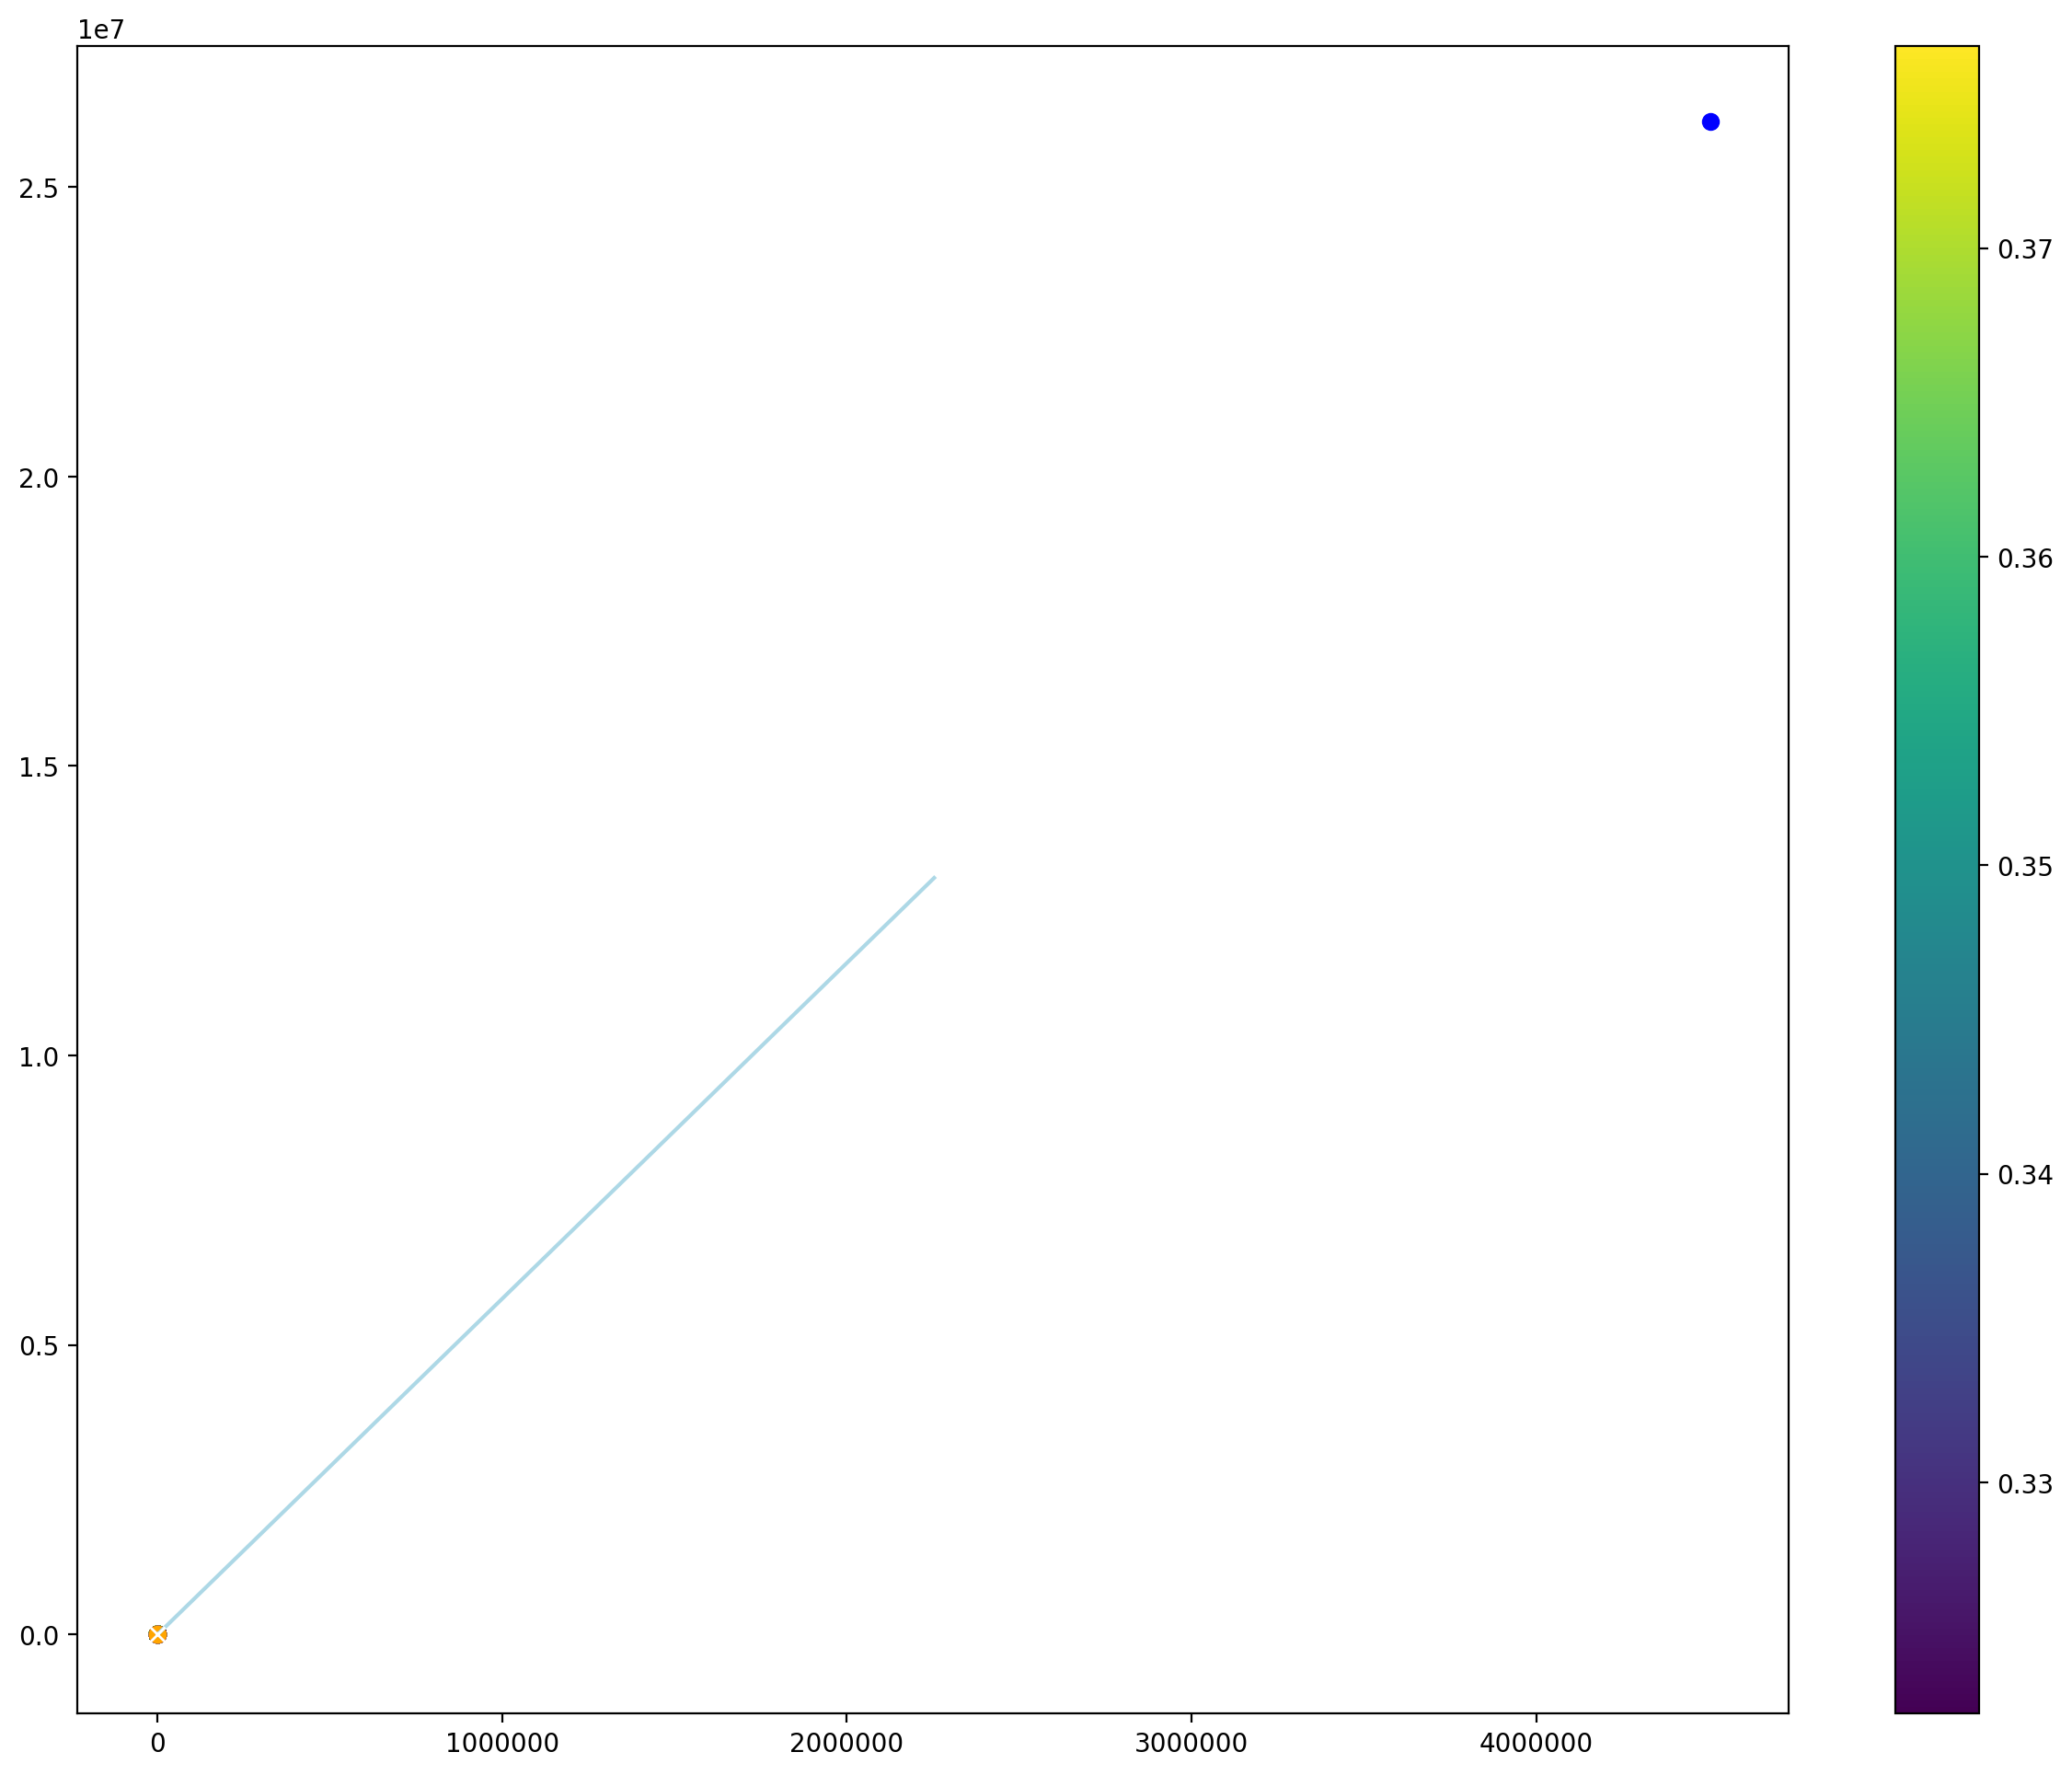

In [546]:
plt.figure(figsize=(15,12),dpi=200)
plt.scatter(xxx,yyy,c=kls2)
plt.colorbar()
plt.scatter(Y[:,0].detach().numpy(),Y[:,1].detach().numpy(),c='gray')
plt.scatter([y_new[0].detach().numpy()],[y_new[1].detach().numpy()],c='red')
plt.scatter([y_newton[0].detach().numpy()],[y_newton[1].detach().numpy()],c='blue')
plt.scatter([y_new_1nn[0]],[y_new_1nn[1]],c='orange')
plt.plot(log_nt[:,0],log_nt[:,1],c='lightblue')
plt.plot(log[:,0],log[:,1],c='pink')
mk =  min(kls2)
mi = [i for i in range(len(kls2)) if kls2[i] ==mk][0]
plt.plot([xxx[mi]],[yyy[mi]],marker='x',c='white')
plt.savefig('test'+str(test_num)+'_wide_x.png',dpi=200)

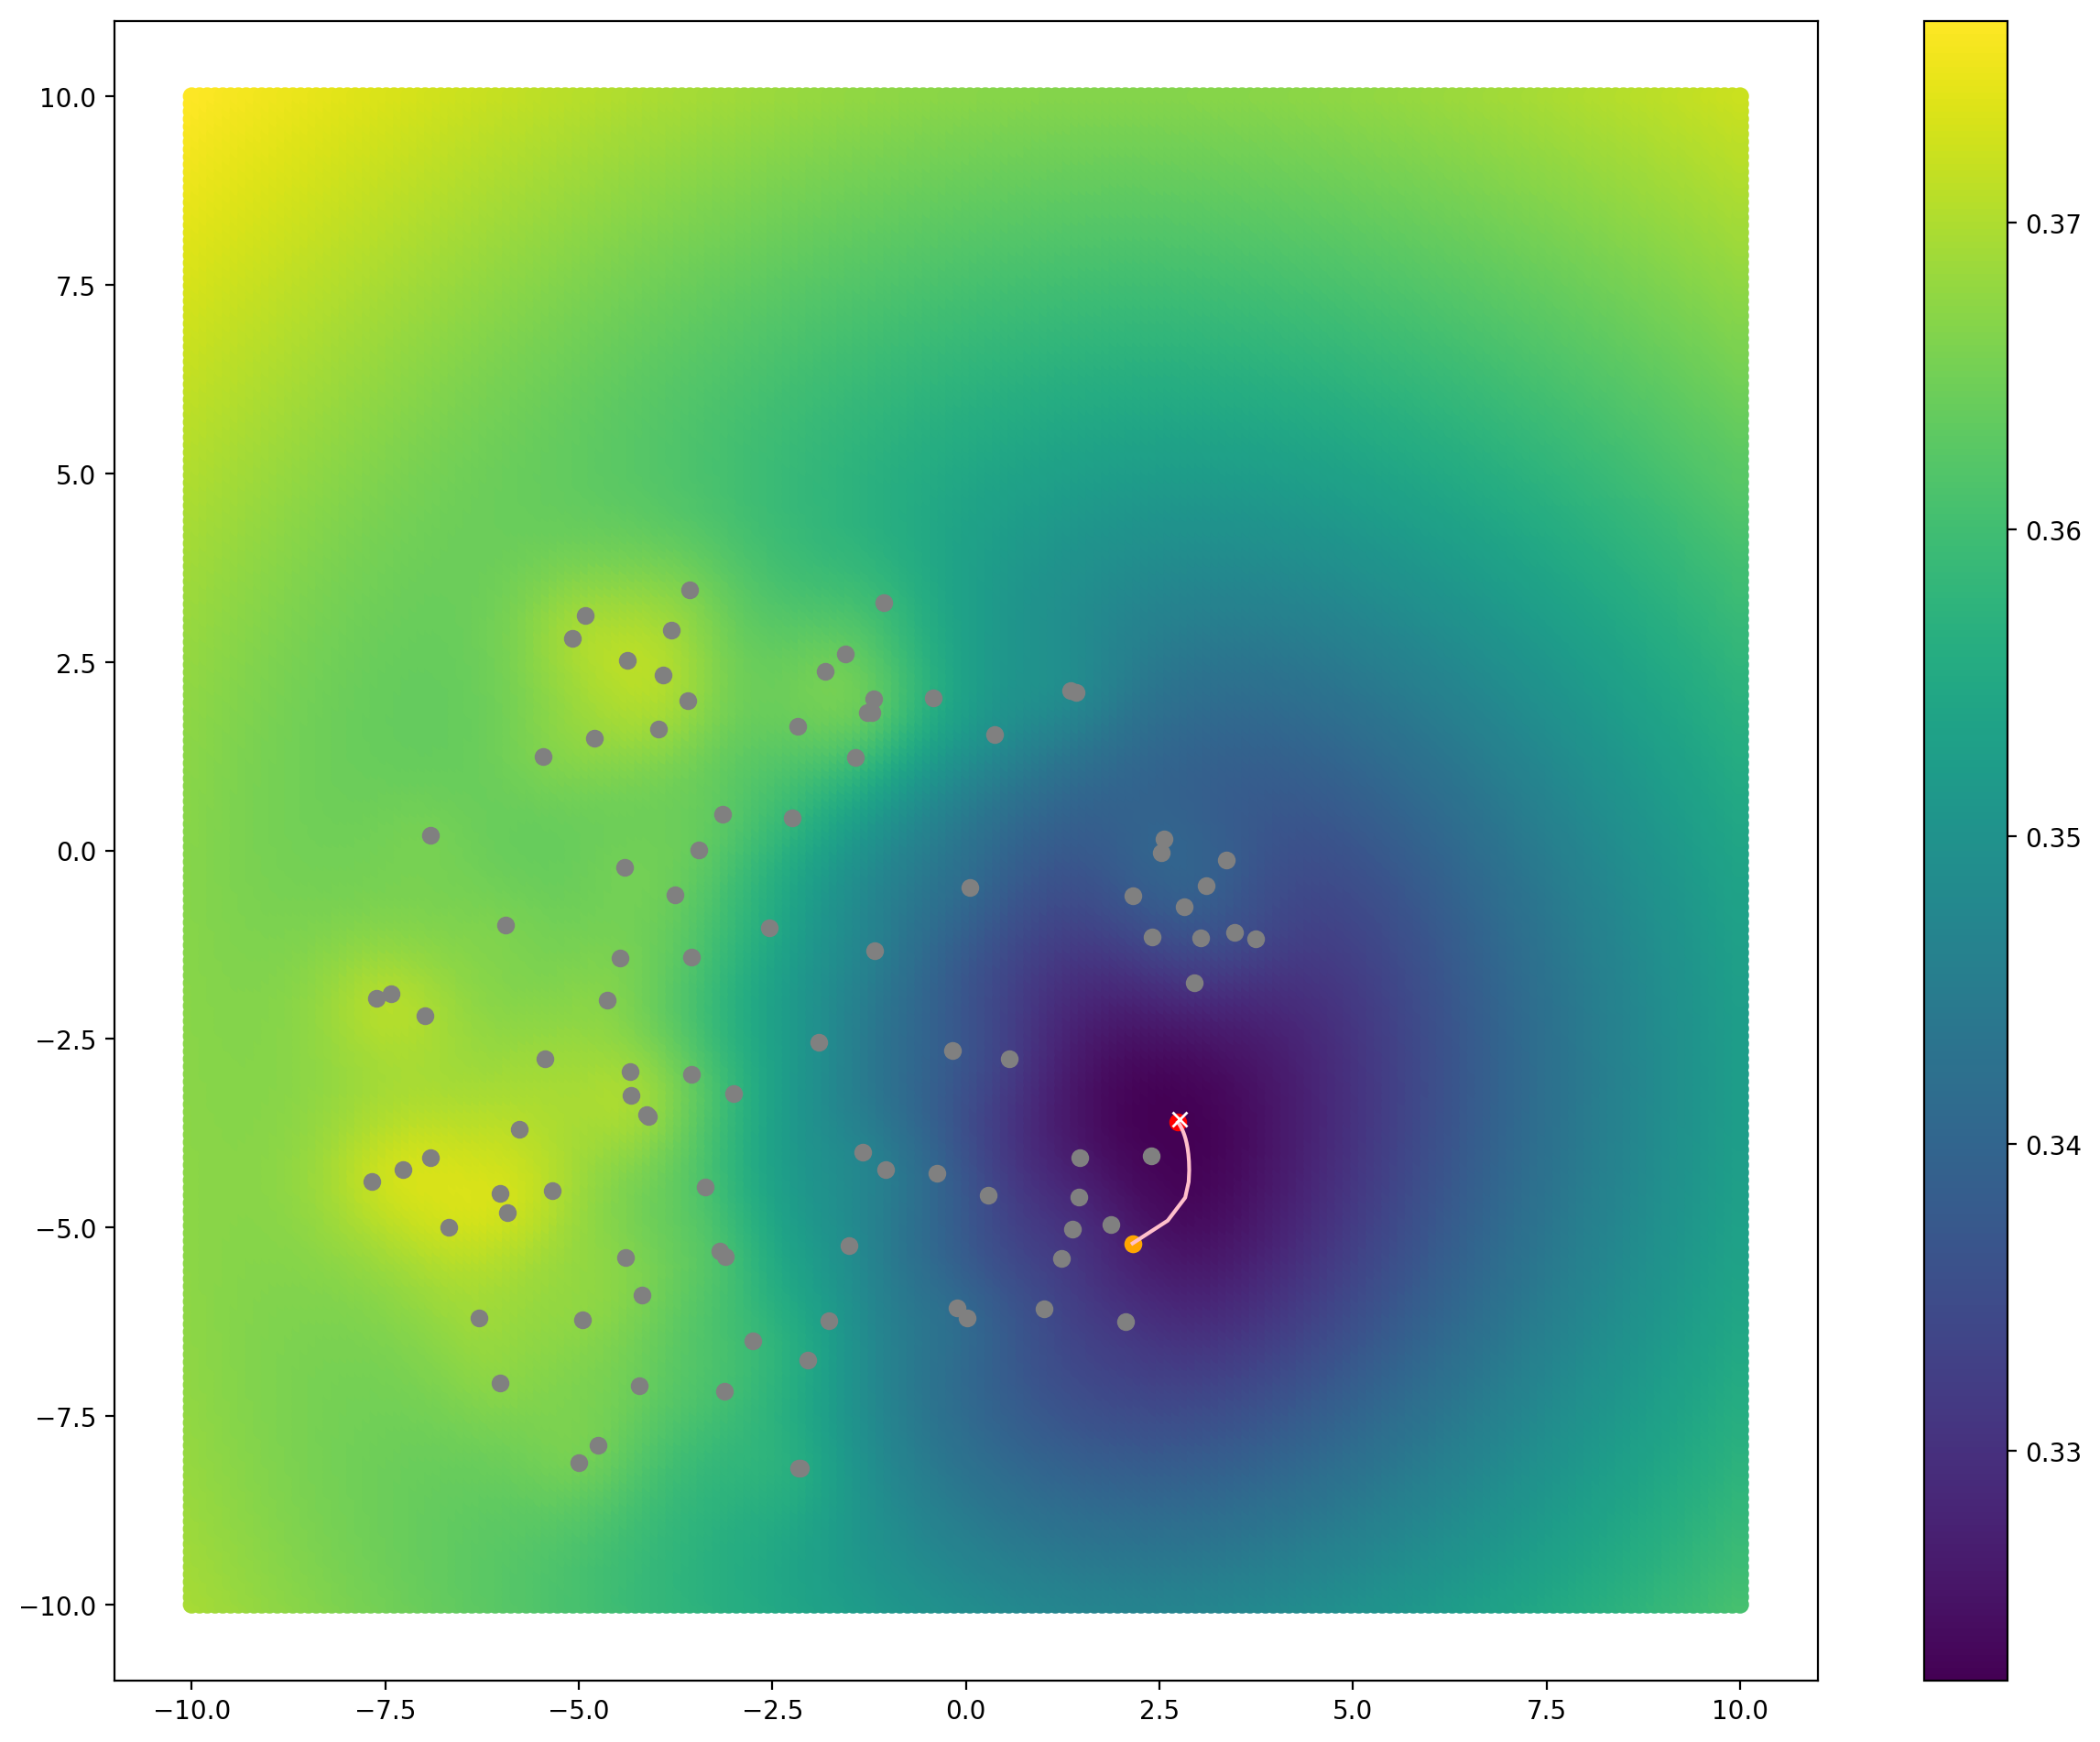

In [547]:
plt.figure(figsize=(15,12),dpi=200)
plt.scatter(xxx,yyy,c=kls2)
plt.colorbar()
plt.scatter(Y[:,0].detach().numpy(),Y[:,1].detach().numpy(),c='gray')
plt.scatter([y_new[0].detach().numpy()],[y_new[1].detach().numpy()],c='red')
#plt.scatter([y_newton[0].detach().numpy()],[y_newton[1].detach().numpy()],c='blue')
plt.scatter([y_new_1nn[0]],[y_new_1nn[1]],c='orange')
#plt.plot(log_nt[:,0],log_nt[:,1],c='lightblue')
plt.plot(log[:,0],log[:,1],c='pink')
mk =  min(kls2)
mi = [i for i in range(len(kls2)) if kls2[i] ==mk][0]
plt.plot([xxx[mi]],[yyy[mi]],marker='x',c='white')
plt.savefig('test'+str(test_num)+'_wide.png',dpi=200)

# built in

In [553]:
def get_reduced_posi_1nn(X, X_reduced,new_x):
    min_dist = 1000
    min_id = 1000000000
    # get new_position
    for j, d in enumerate(X):
        dist = np.linalg.norm(d - new_x)
        if min_dist > dist:
            min_id = j
            min_dist = dist
    return X_reduced[min_id]

def get_high_low(D_l2,sigmas,perp):
    # print('sig,D_l2:',sigmas.shape,D_l2.shape)
    D = torch.exp(-D_l2/(2*torch.pow(sigmas,2).view((sigmas.shape[0],1)))) -\
                                                torch.eye(D_l2.shape[0],dtype=torch.double)
    P = D/D.sum(dim=1).view((D.shape[0],1))
    H = (-P*torch.log2(P+torch.eye(P.shape[0],dtype=torch.double))).sum(dim=1)
    req_perp = torch.tensor(perp, requires_grad=True,dtype=torch.double)
    diff = torch.pow(2,H) - req_perp
    return -torch.sign(diff),diff
    
SIGMAX = 20
def multi_line_search(D_l2,perp):
    l = torch.zeros((D_l2.shape[0],1),dtype=torch.double)
    h = SIGMAX*torch.ones((D_l2.shape[0],1),dtype=torch.double)
    lh = torch.cat((l,h),dim=1)
    A = torch.tensor([[3,1],[1,3]],dtype=torch.double)
    B = torch.tensor([[-1,1],[-1,1]],dtype=torch.double)
    # losses = []
    for i in range(100):
        x,diff = get_high_low(D_l2,lh.mean(dim=1),perp)
        # losses.append(diff.abs().mean().detach().numpy())
        lh = (A@(lh.transpose(0,1)) + B@((lh*x.view((x.shape[0],1))).transpose(0,1)))/4
        lh = lh.transpose(0,1)
        if diff.abs().max() < 1e-2:
            break
    assert lh.max()<20,'you should make SIGMAX larger'
    return lh.mean(dim=1)# ,losses
def line_search(x,P,p,grad):
    c = 1e-4
    rho = 0.8
    alpha = 100.0
    while True:
        if kl_loss(x+alpha*p,Y,P)<= kl_loss(x,Y,P)+c*alpha*grad@p:
            break
        else:
            alpha *= rho
    return alpha*p

def kl_loss(y_new,Y,P):
    Q = get_Q(Y,y_new)
    loss = (P*torch.log(P/Q)).sum()
    return loss

def make_D_l2(x):
    xx = x.expand(x.shape[0],x.shape[0],x.shape[1])
    return torch.pow(xx - xx.transpose(0,1),2).sum(dim=2)

def get_P(D_l2,sigmas):
    D_ = -D_l2/(2*torch.pow(sigmas,2).view((sigmas.shape[0],1)))
    D = torch.exp(D_) - torch.eye(D_l2.shape[0],dtype=torch.double)
    P_ = (D/(D.sum(dim=1).view((D.shape[0],1))))/D.shape[0]
    return (P_ +P_.transpose(0,1))/2+torch.eye(D_l2.shape[0],dtype=torch.double)

def get_Q(Y,y_new):
    Y_new = torch.cat((Y,y_new.view(1,2)))
    D_ = make_D_l2(Y_new)
    Q_ = (1/(1 + D_ ))- torch.eye(D_.shape[0],dtype=torch.double)
    return Q_/Q_.sum() + torch.eye(D_.shape[0],dtype=torch.double)

def find_y_new(P,Y,y_0=[0, 0]):
    y_new = torch.tensor(y_0, requires_grad=True,dtype=torch.double)
    for _ in range(100):
        loss = kl_loss(y_new,Y,P)
        loss.backward()
        grad = y_new.grad
        p = - grad
        stp = line_search(y_new,P,p,grad)
        y_new.data.add_(stp)
        y_new.grad.data.zero_()
        if stp.abs().sum()<1e-3:
            break  
    return y_new# ,log

In [563]:
def get_y_new(X,Y,x_new,perp):
    X_new = torch.cat((X,x_new.view(1,42)))
    D_l2 = make_D_l2(X_new)
    sigmas = multi_line_search(D_l2,perp)
    P = get_P(D_l2,sigmas).detach()
    y_new = torch.tensor([0,0], requires_grad=True,dtype=torch.double)
    y_new = find_y_new(P,Y,y_0=get_reduced_posi_1nn(X.detach().numpy(),Y.detach().numpy(),x_new.detach().numpy()))
    return y_new

# actual use

In [ ]:
perp = 30
X = torch.tensor(train,dtype=torch.double)
Y = torch.tensor(Y, requires_grad=True,dtype=torch.double)
x_new = torch.tensor(test[test_num],dtype=torch.double)

In [564]:
st = time.time()
get_y_new(X,Y,x_new,perp)
print(time.time() - st)

tensor([ 2.7385, -3.6040], dtype=torch.float64, requires_grad=True)

## regacy

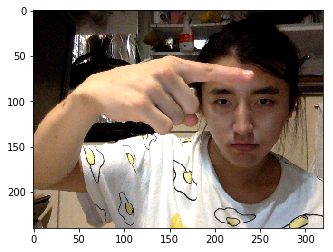

In [59]:
plt.imshow(img)

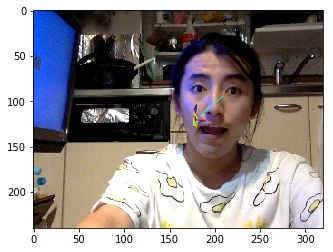

In [62]:
def get_feature(img,sess,sess_args):
    image_v = np.expand_dims((img.astype('float') / 255.0) - 0.5, 0)

    hand_scoremap_v, image_crop_v, scale_v, center_v,\
    keypoints_scoremap_v, keypoint_coord3d_v = sess.run(sess_args,
                                                        feed_dict={image_tf: image_v})
    return keypoints_scoremap_v,scale_v,center_v
keypoints_scoremap_v,scale_v,center_v = get_feature(img,sess,[hand_scoremap_tf, image_crop_tf, scale_tf, center_tf,
                    keypoints_scoremap_tf, keypoint_coord3d_tf])
#center_v = np.array([0.,0.])
#scale_v = np.array([1.])
coord_hw_crop = detect_keypoints(np.squeeze(keypoints_scoremap_v))
coord_hw = trafo_coords(coord_hw_crop, center_v, scale_v, 256)
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.imshow(img)

plot_hand(coord_hw, ax1)

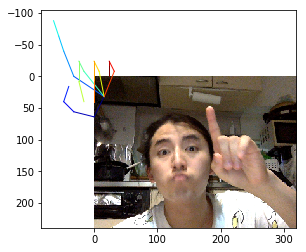

In [61]:
def get_feature(img,sess,sess_args):
    image_v = np.expand_dims((img.astype('float') / 255.0) - 0.5, 0)

    hand_scoremap_v, image_crop_v, scale_v, center_v,\
    keypoints_scoremap_v, keypoint_coord3d_v = sess.run(sess_args,
                                                        feed_dict={image_tf: image_v})
    return keypoints_scoremap_v,scale_v,center_v
keypoints_scoremap_v,scale_v,center_v = get_feature(img,sess,[hand_scoremap_tf, image_crop_tf, scale_tf, center_tf,
                    keypoints_scoremap_tf, keypoint_coord3d_tf])
center_v = np.array([0.,0.])
scale_v = np.array([1.])
coord_hw_crop = detect_keypoints(np.squeeze(keypoints_scoremap_v))
coord_hw = trafo_coords(coord_hw_crop, center_v, scale_v, 256)
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.imshow(img)

plot_hand(coord_hw, ax1)

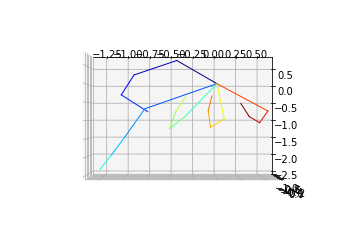

In [36]:
def get_feature(img,sess,sess_args):
    image_v = np.expand_dims((img.astype('float') / 255.0) - 0.5, 0)

    hand_scoremap_v, image_crop_v, scale_v, center_v,\
    keypoints_scoremap_v, keypoint_coord3d_v = sess.run(sess_args,
                                                        feed_dict={image_tf: image_v})
    return keypoint_coord3d_v
    
keypoint_coord3d_v = get_feature(img,sess,[hand_scoremap_tf, image_crop_tf, scale_tf, center_tf,
                    keypoints_scoremap_tf, keypoint_coord3d_tf])
keypoint_coord3d_v = np.squeeze(keypoint_coord3d_v)
fig = plt.figure(1)
#ax4 = fig.add_subplot(224, projection='3d')
ax4 = fig.add_subplot(111, projection='3d')
plot_hand_3d(keypoint_coord3d_v, ax4)

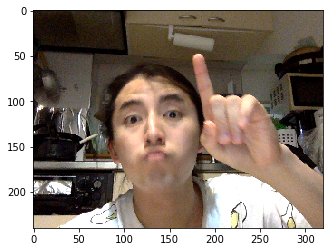

In [37]:
plt.imshow(img)